In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [29]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import pandas as pd
import scipy.stats as ss
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('husl', n_colors=6)
sns.set_style('ticks')

Posterior sample file dowloaded from https://dcc.ligo.org/LIGO-P2000158/public.  There are multiple approximants in the file, but the "preferred" results come from a "NR surrogate" `NRSur7dq4`:

In [9]:
with h5py.File('GW190521_posterior_samples.h5', 'r') as f:
    samples = array(f['NRSur7dq4/posterior_samples'])

In [13]:
np.random.SeedSequence().entropy

227735503557159763068367766824777508503

In [31]:
rng = np.random.default_rng(227735503557159763068367766824777508503)
c = rng.choice(len(samples), replace=False, size=16384)
sky_samples = pd.DataFrame({
    'x': samples['luminosity_distance'][c]*cos(samples['ra'][c])*cos(samples['dec'][c]),
    'y': samples['luminosity_distance'][c]*sin(samples['ra'][c])*cos(samples['dec'][c]),
    'z': samples['luminosity_distance'][c]*sin(samples['dec'][c])
})
sky_samples_plot = pd.DataFrame({
    r'$x$ ($\mathrm{Mpc}$)': samples['luminosity_distance'][c]*cos(samples['ra'][c])*cos(samples['dec'][c]),
    r'$y$ ($\mathrm{Mpc}$)': samples['luminosity_distance'][c]*sin(samples['ra'][c])*cos(samples['dec'][c]),
    r'$z$ ($\mathrm{Mpc}$)': samples['luminosity_distance'][c]*sin(samples['dec'][c])
})

[Graham, et al. (2020)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.124.251102) reports the AGN at $\mathrm{RA} = 192.42625^\circ$, $\mathrm{DEC} = 34.82472^\circ$, and $z = 0.438$.  Converting to $xyz$ we have 

In [27]:
ra = 192.42625*pi/180.0
dec = 34.82472*pi/180
z = 0.438
d = Planck15.luminosity_distance(z).to(u.Mpc).value
xcounter = d*cos(ra)*cos(dec)
ycounter = d*sin(ra)*cos(dec)
zcounter = d*sin(dec)

pt_counter = array([xcounter, ycounter, zcounter])

This is a pretty typical skymap: there are two blobs on the sky.  It would be better to do some clustering or use the routines in https://lscsoft.docs.ligo.org/ligo.skymap/#plotting-and-visualization-ligo-skymap-plot, but we're being quick and dirty here.

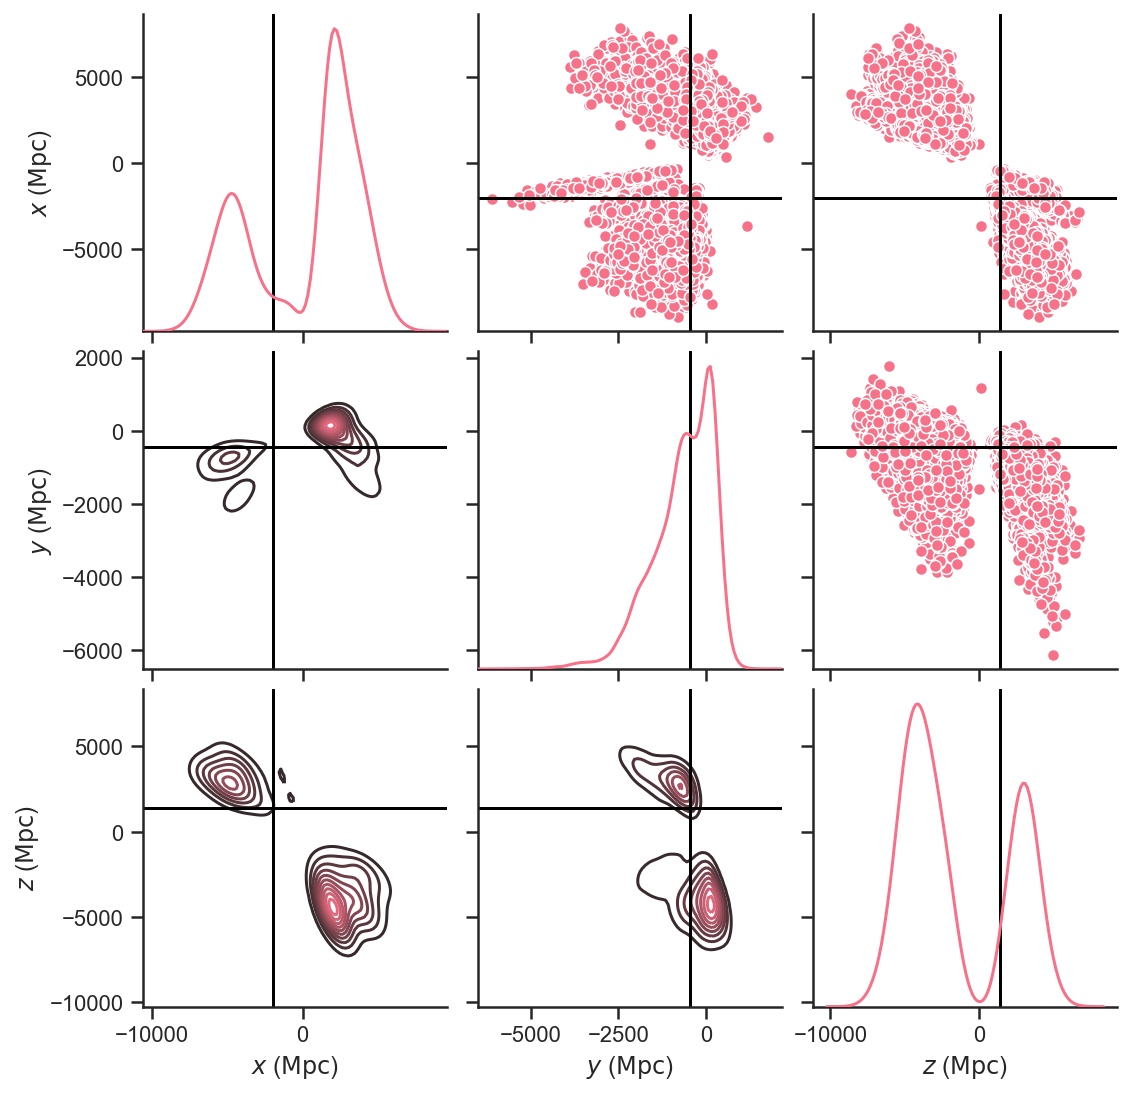

In [28]:
g = sns.PairGrid(sky_samples, diag_sharey=False)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)

for i in range(3):
    for j in range(3):
        if i == j:
            g.axes[i,j].axvline(pt_counter[i], color='k')
        else:
            g.axes[i,j].axhline(pt_counter[i], color='k')
            g.axes[i,j].axvline(pt_counter[j], color='k')

To get a quick sense of the fraction of the volume posterior that would have to be searched before landing on the AGN, we rank the posterior samples according to an estimate of their 3D posterior density, and determine what fraction lie at lower rank than the AGN location.

In [34]:
pts = row_stack((sky_samples['x'], sky_samples['y'], sky_samples['z']))
kde = ss.gaussian_kde(pts)
p_pts = kde(pts)
p_counterpart = kde(pt_counter)

print('AGN lies at the {:.2f} percentile of the posterior'.format(count_nonzero(p_pts > p_counterpart) / float(len(p_pts))))

AGN lies at the 0.82 percentile of the posterior
